In [19]:
# timing_model.py
# Defines the basic timing model interface classes
import functools
from pint.models.parameter import strParameter
from pint.phase import Phase
from astropy import log
import astropy.time as time
import numpy as np
import pint.utils as utils
import astropy.units as u
import copy
import abc
from six import add_metaclass
import astropy.coordinates as coords
import astropy.constants as const
from astropy.coordinates.angles import Angle
from astropy import log
from pint.models import parameter as p
from pint.models.timing_model import MissingParameter, Cache
from pint.utils import time_from_mjd_string, time_to_longdouble, str2longdouble
from pint.pulsar_ecliptic import PulsarEcliptic, OBL
from pint import ls
from pint import utils
import time
import matplotlib.pyplot as plt
%matplotlib inline

mas_yr = (u.mas / u.yr)

try:
    from astropy.erfa import DAYSEC as SECS_PER_DAY
except ImportError:
    from astropy._erfa import DAYSEC as SECS_PER_DAY


Define the TimingModel class

In [2]:
ignore_params = ['START', 'FINISH', 'SOLARN0', 'EPHEM', 'CLK', 'UNITS',
                 'TIMEEPH', 'T2CMETHOD', 'CORRECT_TROPOSPHERE', 'DILATEFREQ',
                 'NTOA', 'CLOCK', 'TRES', 'TZRMJD', 'TZRFRQ', 'TZRSITE',
                 'NITS', 'IBOOT','BINARY']
ignore_prefix = ['DMXF1_','DMXF2_','DMXEP_'] # DMXEP_ for now.

class TimingModelc(object):
    """This is a class that holds all the model component as a composition style.
       The result should be the same to the orginal TimingModel style.
       Parameters
       ----------
       comps : optional
           The timing modle components to placed into the TimingModel.
    """
    def __init__(self, comps=[]):
        self.comp_list = {}
        self.delays = []
        self.phases = []
        self.delay_comps = []
        self.phase_comps = []
        self.param_map = {}
        self.componet_type_map = {'phase':'phases',
                                  'delay':'delays'}
        self.add_comps(comps)
    
    def __getattr__(self, name):
        if name in self.params:
            cpname = self.param_map[name]
            cp = self.comp_list[cpname]
            return cp.__getattribute__(name)
        else:
            super(TimingModelc, self).__getattr__(name)
    
    @property
    def params(self,):
        return self.param_map.keys()
    
    def add_param(self, param, comp=''):
        pass            
    def add_comps(self, comps):
        if not isinstance(comps, (list, tuple)):
            comps = [comps,]
        for cp in comps:
            cpname = cp.__class__.__name__
            self.comp_list[cpname] = cp
            cp._parent = self
            cp_type = cp.component_type
            if cp_type in self.componet_type_map.keys():
                getattr(self, self.componet_type_map[cp_type]).append(cpname)
            else:
                new_cp_type = cp_type+'s'
                setattr(self, new_cp_type, [cpname,])
            for param in cp.params:
                self.param_map[param] = cpname
                
    def remove_comps(self, comps_name):
        pass
    def delay(self, toas):
        # We can put order here. For now it will be kept like this
        delay = np.zeros(len(toas))
        for cp in self.delays:
            dfs = self.comp_list[cp].delay_funcs
            for df in dfs:
                delay += df(toas)
        return delay
    
    def phase(self, toas):
    # First compute the delays to "pulsar time"
        delay = self.delay(toas)
        phase = Phase(np.zeros(len(toas)), np.zeros(len(toas)))
        # Then compute the relevant pulse phases
        for cp in self.phases:
            pfs = self.comp_list[cp].phase_funcs
            for pf in pfs:
                phase += Phase(pf(toas, delay))     
        return phase
    
    def read_parfile(self, filename):
        """Read values from the specified parfile into the model parameters."""
        checked_param = []
        repeat_param = {}
        pfile = open(filename, 'r')
        for l in [pl.strip() for pl in pfile.readlines()]:
            # Skip blank lines
            if not l:
                continue
            # Skip commented lines
            if l.startswith('#') or l[:2]=="C ":
                continue

            k = l.split()
            name = k[0].upper()

            if name in checked_param:
                if name in repeat_param.keys():
                    repeat_param[name] += 1
                else:
                    repeat_param[name] = 2
                k[0] = k[0] + str(repeat_param[name])
                l = ' '.join(k)

            parsed = False
            for par in self.params:
                cp = self.param_map[par]
                if getattr(self.comp_list[cp], par).from_parfile_line(l):
                    parsed = True
            if not parsed:
                try:
                    prefix,f,v = utils.split_prefixed_name(l.split()[0])
                    if prefix not in ignore_prefix:
                        log.warn("Unrecognized parfile line '%s'" % l)
                except:
                    if l.split()[0] not in ignore_params:
                        log.warn("Unrecognized parfile line '%s'" % l)

            checked_param.append(name)
        # The "setup" functions contain tests for required parameters or
        # combinations of parameters, etc, that can only be done
        # after the entire parfile is read
        for cp in self.comp_list.values():
            cp.setup()

Define the component class

In [3]:
class Component(object):
    def __init__(self,):
        self._parent = None
        self.params = []
        self.order_number = None
    def setup(self,):
        pass
         
    def add_param(self, param):
        setattr(self, param.name, param)
        self.params += [param.name,] 
    
    def set_special_params(self, spcl_params):
        als = []
        for p in spcl_params:
            als += getattr(self, p).aliases
        spcl_params += als
        self.model_special_params = spcl_params
        
    def getattr_from(self, name, source):
        if isinstance(source, str):
            if self._parent is not None and \
            source in list(self._parent.comp_list.keys()):
                return getattr(self._parent.comp_list[source], name)
            else:
                raise AttributeError("Can not find %s from Timing " \
                                     "Model class", source)
        else:
            return getattr(source, name)
    
    def param_help(self):
        """Print help lines for all available parameters in model.
        """
        s = "Available parameters for %s\n" % self.__class__
        for par in self.params:
            s += "%s\n" % getattr(self, par).help_line()
        return s

    def get_params_of_type(self, param_type):
        """ Get all the parameters in timing model for one specific type
        """
        result = []
        for p in self.params:
            par = getattr(self, p)
            par_type = type(par).__name__
            par_prefix = par_type[:-9]
            if param_type.upper() == par_type.upper() or \
                param_type.upper() == par_prefix.upper():
                result.append(par.name)
        return result

    #@Cache.use_cache
    def get_prefix_mapping(self,prefix):
        """Get the index mapping for the prefix parameters.
           Parameter
           ----------
           prefix : str
               Name of prefix.
           Return
           ----------
           A dictionary with prefix pararameter real index as key and parameter
           name as value.
        """
        parnames = [x for x in self.params if x.startswith(prefix)]
        mapping = dict()
        for parname in parnames:
            par = getattr(self, parname)
            if par.is_prefix == True and par.prefix == prefix:
                mapping[par.index] = parname
        return mapping

    def match_param_aliases(self, alias):
        p_aliases = {}
        # if alias is a parameter name, return itself
        if alias in self.params:
            return alias
        # get all the aliases
        for p in self.params:
            par = getattr(self, p)
            if par.aliases !=[]:
                p_aliases[p] = par.aliases
        # match alias
        for pa, pav in zip(p_aliases.keys(), p_aliases.values()):
            if alias in pav:
                return pa
        # if not found any thing.
        return ''           

class DelayComponent(Component):
    def __init__(self,):
        super(DelayComponent, self).__init__()
        self.params = []
        self.delay_funcs = []
        self.component_type = 'delay'
        
class PhaseComponent(Component):
    def __init__(self,):
        super(PhaseComponent, self).__init__()
        self.params = []
        self.phase_funcs = []
        self.component_type = 'phase'
    

Define astrometry delay component

In [4]:
import astropy.coordinates as coords
import astropy.constants as const
from astropy.coordinates.angles import Angle
from astropy import log
import pint.models.parameter as p
from pint.models.timing_model import TimingModel, MissingParameter, Cache
from pint.utils import time_from_mjd_string, time_to_longdouble, str2longdouble
from pint import ls
from pint import utils
import time

mas_yr = (u.mas / u.yr)

try:
    from astropy.erfa import DAYSEC as SECS_PER_DAY
except ImportError:
    from astropy._erfa import DAYSEC as SECS_PER_DAY

class Astrometry(DelayComponent):
    register = True
    def __init__(self):
        super(Astrometry, self).__init__()
        self.add_param(p.MJDParameter(name="POSEPOCH",
            description="Reference epoch for position"))

        self.add_param(p.floatParameter(name="PX",
            units="mas", value=0.0,
            description="Parallax"))

        self.delay_funcs += [self.solar_system_geometric_delay,]
        self.order_number = 0

    def setup(self):
        super(Astrometry, self).setup()
    # @Cache.cache_result
    def ssb_to_psb_xyz(self, epoch=None):
        """Returns unit vector(s) from SSB to pulsar system barycenter.

        If epochs (MJD) are given, proper motion is included in the calculation.
        """
        # TODO: would it be better for this to return a 6-vector (pos, vel)?
        return self.coords_as_ICRS(epoch=epoch).cartesian.xyz.transpose()

    # @Cache.cache_result
    def barycentric_radio_freq(self, toas):
        """Return radio frequencies (MHz) of the toas corrected for Earth motion"""
        L_hat = self.ssb_to_psb_xyz(epoch=toas['tdbld'].astype(numpy.float64))
        v_dot_L_array = numpy.sum(toas['ssb_obs_vel']*L_hat, axis=1)
        return toas['freq'] * (1.0 - v_dot_L_array / const.c)

    def solar_system_geometric_delay(self, toas):
        """Returns geometric delay (in sec) due to position of site in
        solar system.  This includes Roemer delay and parallax.

        NOTE: currently assumes XYZ location of TOA relative to SSB is
        available as 3-vector toa.xyz, in units of light-seconds.
        """
        L_hat = self.ssb_to_psb_xyz(epoch=toas['tdbld'].astype(numpy.float64))
        re_dot_L = numpy.sum(toas['ssb_obs_pos']*L_hat, axis=1)
        delay = -re_dot_L.to(ls).value
        if self.PX.value != 0.0 \
           and numpy.count_nonzero(toas['ssb_obs_pos']) > 0:
            L = ((1.0 / self.PX.value) * u.kpc)
            # TODO: numpy.sum currently loses units in some cases...
            re_sqr = numpy.sum(toas['ssb_obs_pos']**2, axis=1) * toas['ssb_obs_pos'].unit**2
            delay += (0.5 * (re_sqr / L) * (1.0 - re_dot_L**2 / re_sqr)).to(ls).value
        return delay
    

class AstrometryEquatorial(Astrometry):
    register = True
    def __init__(self):
        super(AstrometryEquatorial, self).__init__()
        self.add_param(p.AngleParameter(name="RAJ",
            units="H:M:S",
            description="Right ascension (J2000)",
            aliases=["RA"]))

        self.add_param(p.AngleParameter(name="DECJ",
            units="D:M:S",
            description="Declination (J2000)",
            aliases=["DEC"]))

        self.add_param(p.floatParameter(name="PMRA",
            units="mas/year", value=0.0,
            description="Proper motion in RA"))

        self.add_param(p.floatParameter(name="PMDEC",
            units="mas/year", value=0.0,
            description="Proper motion in DEC"))
        self.set_special_params(['RAJ', 'DECJ', 'PMRA', 'PMDEC'])
        self.print_par_func = 'print_par_AstrometryEquatorial'

    def setup(self):
        super(AstrometryEquatorial, self).setup()
        # RA/DEC are required
        for p in ("RAJ", "DECJ"):
            if getattr(self, p).value is None:
                raise MissingParameter("Astrometry", p)
        # If PM is included, check for POSEPOCH
        if self.PMRA.value != 0.0 or self.PMDEC.value != 0.0:
            if self.POSEPOCH.quantity is None:
                if self.PEPOCH.quantity is None:
                    raise MissingParameter("AstrometryEquatorial", "POSEPOCH",
                            "POSEPOCH or PEPOCH are required if PM is set.")
                else:
                    self.POSEPOCH.quantity = self.PEPOCH.quantity

    def print_par_AstrometryEquatorial(self):
        result = ''
        print_order = ['RAJ', 'DECJ', 'PMRA', 'PMDEC', 'PX', 'POSEPOCH']
        for p in print_order:
            par = getattr(self, p)
            if par.quantity is not None:
                result += getattr(self, p).as_parfile_line()
        return result

    #@Cache.cache_result
    def coords_as_ICRS(self, epoch=None):
        """Returns pulsar sky coordinates as an astropy ICRS object instance.

        If epoch (MJD) is specified, proper motion is included to return
        the position at the given epoch.

        If the ecliptic coordinates are provided,
        """
        if epoch is None or (self.PMRA.value == 0.0 and self.PMDEC.value == 0.0):
            return coords.ICRS(ra=self.RAJ.quantity, dec=self.DECJ.quantity)
        else:
            dt = (epoch - self.POSEPOCH.quantity.mjd) * u.d
            dRA = dt * self.PMRA.quantity / numpy.cos(self.DECJ.quantity.radian)
            dDEC = dt * self.PMDEC.quantity
            return coords.ICRS(ra=self.RAJ.quantity+dRA, dec=self.DECJ.quantity+dDEC)

    

Define solar system shapiro delay component

In [5]:
from pint import Tsun, Tmercury, Tvenus, Tearth, Tmars, \
        Tjupiter, Tsaturn, Turanus, Tneptune

class SolarSystemShapiro(DelayComponent):
    register = True
    def __init__(self):
        super(SolarSystemShapiro, self).__init__()

        self.add_param(p.boolParameter(name="PLANET_SHAPIRO",
             value=False, description="Include planetary Shapiro delays (Y/N)"))
        self.delay_funcs += [self.solar_system_shapiro_delay,]

    def setup(self):
        super(SolarSystemShapiro, self).setup()

    # Put masses in a convenient dictionary
    _ss_mass_sec = {"sun": Tsun.value,
                    "mercury": Tmercury.value,
                    "venus": Tvenus.value,
                    "earth": Tearth.value,
                    "mars": Tmars.value,
                    "jupiter": Tjupiter.value,
                    "saturn": Tsaturn.value,
                    "uranus": Turanus.value,
                    "neptune": Tneptune.value}

    @staticmethod
    def ss_obj_shapiro_delay(obj_pos, psr_dir, T_obj):
        """
        ss_obj_shapiro_delay(obj_pos, psr_dir, T_obj)

        returns Shapiro delay in seconds for a solar system object.

        Inputs:
          obj_pos : position vector from Earth to SS object, with Units
          psr_dir : unit vector in direction of pulsar
          T_obj : mass of object in seconds (GM/c^3)
        """
        # TODO: numpy.sum currently loses units in some cases...
        r = (numpy.sqrt(numpy.sum(obj_pos**2, axis=1))) * obj_pos.unit
        rcostheta = numpy.sum(obj_pos*psr_dir, axis=1)
        # This formula copied from tempo2 code.  The sign of the
        # cos(theta) term has been changed since we are using the
        # opposite convention for object position vector (from
        # observatory to object in this code).
        # Tempo2 uses the postion vector sign differently between the sun and planets
        return -2.0 * T_obj * numpy.log((r-rcostheta)/const.au).value

    def solar_system_shapiro_delay(self, toas):
        """
        Returns total shapiro delay to due solar system objects.
        If the PLANET_SHAPIRO model param is set to True then
        planets are included, otherwise only the value for the
        Sun is calculated.

        Requires Astrometry or similar model that provides the
        ssb_to_psb_xyz method for direction to pulsar.

        If planets are to be included, TOAs.compute_posvels() must
        have been called with the planets=True argument.
        """
        # Start out with 0 delay with units of seconds
        delay = numpy.zeros(len(toas))
        # This line will have a problem, since we don't know if 
        # AstrometryEquatorial is the astrometry class we are going to use. 
        ssb2psb_xyz = self.getattr_from('ssb_to_psb_xyz', 'AstrometryEquatorial')
        for ii, key in enumerate(toas.groups.keys):
            grp = toas.groups[ii]
            obs = toas.groups.keys[ii]['obs']
            loind, hiind = toas.groups.indices[ii:ii+2]
            if key['obs'].lower() == 'barycenter':
                log.info("Skipping Shapiro delay for Barycentric TOAs")
                continue
            
            psr_dir = ssb2psb_xyz(epoch=grp['tdbld'].astype(numpy.float64))
            delay[loind:hiind] += self.ss_obj_shapiro_delay(grp['obs_sun_pos'],
                                    psr_dir, self._ss_mass_sec['sun'])
            if self.PLANET_SHAPIRO.value:
                for pl in ('jupiter', 'saturn', 'venus', 'uranus'):
                    delay[loind:hiind] += self.ss_obj_shapiro_delay(grp['obs_'+pl+'_pos'],
                                                   psr_dir, self._ss_mass_sec[pl])
        return delay


Define thd spindown phase

In [6]:
from pint.phase import *
from pint.utils import time_from_mjd_string, time_to_longdouble, str2longdouble,\
    taylor_horner, time_from_longdouble, split_prefixed_name, taylor_horner_deriv



class Spindown(PhaseComponent):
    """This class provides a simple timing model for an isolated pulsar."""
    register = True
    def __init__(self):
        super(Spindown, self).__init__()

        # The number of terms in the taylor exapansion of spin freq (F0...FN)
        #self.num_spin_terms = maxderivs

        self.add_param(p.floatParameter(name="F0", value=0.0, units="Hz",
                       description="Spin-frequency", long_double=True))

        self.add_param(p.prefixParameter(name="F1", value=0.0, units='Hz/s^1',
                       description="Spindown-rate",
                       unit_template=self.F_unit,
                       description_template=self.F_description,
                       type_match='float', long_double=True))

        self.add_param(p.MJDParameter(name="TZRMJD",
                       description="Reference epoch for phase = 0.0",
                       time_scale='tdb'))

        self.add_param(p.MJDParameter(name="PEPOCH",
                       description="Reference epoch for spin-down",
                       time_scale='tdb'))

        self.phase_funcs += [self.spindown_phase,]
        self.order_number = 1
        self.print_par_func = 'print_par_F'

    def setup(self):
        super(Spindown, self).setup()
        # Check for required params
        for p in ("F0",):
            if getattr(self, p).value is None:
                raise MissingParameter("Spindown", p)

        # Check continuity
        F_terms = list(self.get_prefix_mapping('F').keys())
        F_terms.sort()
        F_in_order = list(range(1, max(F_terms)+1))
        if not F_terms == F_in_order:
            diff = list(set(F_in_order) - set(F_terms))
            raise MissingParameter("Spindown", "F%d"%diff[0])

        # If F1 is set, we need PEPOCH
        if self.F1.value != 0.0:
            if self.PEPOCH.value is None:
                raise MissingParameter("Spindown", "PEPOCH",
                        "PEPOCH is required if F1 or higher are set")
        self.num_spin_terms = len(F_terms) + 1
        
    def F_description(self, n):
        """Template function for description"""
        return "Spin-frequency %d derivative" % n if n else "Spin-frequency"

    def F_unit(self, n):
        """Template function for unit"""
        return "Hz/s^%d" % n if n else "Hz"

    def get_spin_terms(self):
        """Return a list of the spin term values in the model: [F0, F1, ..., FN]
        """
        return [getattr(self, "F%d" % ii).value for ii in
                range(self.num_spin_terms)]

    def get_dt(self, toas, delay):
        # If TZRMJD is not defined, use the first time as phase reference
        # NOTE, all of this ignores TZRSITE and TZRFRQ for the time being.
        # TODO: TZRMJD should be set by default somewhere in a standard place,
        #       after the TOAs are loaded (RvH -- June 2, 2015)
        # NOTE: Should we be using barycentric arrival times, instead of TDB?
        if self.TZRMJD.value is None:
            self.TZRMJD.value = toas['tdb'][0] - delay[0]*u.s
        # Warning(paulr): This looks wrong.  You need to use the
        # TZRFREQ and TZRSITE to compute a proper TDB reference time.
        if not hasattr(self, "TZRMJDld"):
            self.TZRMJDld = time_to_longdouble(self.TZRMJD.value)

        dt_tzrmjd = (toas['tdbld'] - self.TZRMJDld) * SECS_PER_DAY - delay
        # TODO: what timescale should we use for pepoch calculation? Does this even matter?
        dt_pepoch = (time_to_longdouble(self.PEPOCH.value) - self.TZRMJDld) * SECS_PER_DAY
        return dt_tzrmjd, dt_pepoch

    def spindown_phase(self, toas, delay):
        """Spindown phase function.

        delay is the time delay from the TOA to time of pulse emission
          at the pulsar, in seconds.

        This routine should implement Eq 120 of the Tempo2 Paper II (2006, MNRAS 372, 1549)

        returns an array of phases in long double
        """
        dt_tzrmjd, dt_pepoch = self.get_dt(toas, delay)
        # Add the [0.0] because that is the constant phase term
        fterms = [0.0] + self.get_spin_terms()
        phs_tzrmjd = taylor_horner(dt_tzrmjd-dt_pepoch, fterms)
        phs_pepoch = taylor_horner(-dt_pepoch, fterms)
        return phs_tzrmjd - phs_pepoch

    def print_par_F(self,):
        result = ''
        f_terms = ["F%d" % ii for ii in
                range(self.num_spin_terms)]
        for ft in f_terms:
            par = getattr(self, ft)
            result += par.as_parfile_line()
        if hasattr(self, 'components'):
            p_default = self.components['Spindown'].params
        else:
            p_default = self.params
        for param in p_default:
            if param not in f_terms:
                result += getattr(self, param).as_parfile_line()
        return result

    def d_phase_d_F(self, toas, param, delay):
        """Calculate the derivative wrt to an spin term."""
        par = getattr(self, param)
        unit = par.units
        pn, idxf, idxv = split_prefixed_name(param)
        order = idxv + 1
        fterms = [0.0] + self.get_spin_terms()
        # make the choosen fterms 1 others 0
        fterms = numpy.longdouble(numpy.zeros(len(fterms)))
        fterms[order] = numpy.longdouble(1.0)
        dt_tzrmjd, dt_pepoch = self.get_dt(toas, delay)
        d_ptzrmjd_d_f = taylor_horner(dt_tzrmjd-dt_pepoch, fterms)
        d_ppepoch_d_f = taylor_horner(-dt_pepoch, fterms)
        return (d_ptzrmjd_d_f - d_ppepoch_d_f) * u.Unit("")/unit

    def d_spindown_phase_d_delay(self, toas, delay):
        dt_tzrmjd, dt_pepoch = self.get_dt(toas, delay)
        fterms = [0.0] + self.get_spin_terms()
        d_ptzrmjd_d_delay = taylor_horner_deriv(dt_tzrmjd-dt_pepoch, fterms)
        return -d_ptzrmjd_d_delay * u.Unit("")/u.second


In [7]:
ad = AstrometryEquatorial()
sd = SolarSystemShapiro()
sp = Spindown()

In [8]:
m = TimingModelc(comps = [ad, sd, sp])

In [9]:
m.read_parfile('NGC6440E.par')

In [10]:
print m.params

['F0', 'POSEPOCH', 'PLANET_SHAPIRO', 'TZRMJD', 'DECJ', 'F1', 'PX', 'RAJ', 'PMDEC', 'PEPOCH', 'PMRA']


In [11]:
import pint.toa as toa

In [12]:
t = toa.get_TOAs('NGC6440E.tim')

INFO: Applying clock corrections. [pint.toa]
INFO: Observatory gbt, loading clock file /Users/jingluo/Research_codes/PINT/pint/datafiles/time.dat [pint.observatory.topo_obs]
INFO: Observatory gbt, loading GPS clock file /Users/jingluo/Research_codes/PINT/pint/datafiles/gps2utc.clk [pint.observatory.topo_obs]
INFO: Observatory gbt, loading BIPM clock file /Users/jingluo/Research_codes/PINT/pint/datafiles/tai2tt_bipm2015.clk [pint.observatory.topo_obs]
INFO: Getting IERS params and computing TDBs. [pint.toa]
INFO: Computing TDB columns. [pint.toa]
INFO: Computing observatory positions and velocities. [pint.toa]
INFO: Compute positions and velocities of observatories and Earth (planets = False), using DE421 ephemeris [pint.toa]
INFO: Adding columns ssb_obs_pos ssb_obs_vel obs_sun_pos [pint.toa]


In [13]:
m.delay(t.table)

array([-256.52226897, -292.42173698, -333.99542817,  356.83991239,
        356.83990909,  356.8399065 ,  356.83990442,  356.83990772,
        367.44949838,  368.89399894,  378.83582271,  389.56015652,
        399.55403357,  400.87201875,  414.78347697,  435.6538666 ,
        436.30218353,  453.99665642,  454.48105078,  477.79766711,
        478.13944805,  468.21964041,  467.67117582,   94.12404605,
         92.38460168, -176.06231021, -177.70973856, -253.77356808,
       -394.46071636, -395.48136602, -497.48443612, -497.7846944 ,
       -488.81546678, -488.42216718, -337.43868237, -336.15984912,
       -146.81821629, -145.05036715,  105.54368062,  107.29791384,
        389.00150729,  390.27387741,  490.16478511,  488.228923  ,
        484.16922108,  482.44298419,  239.84540985,  226.61270385,
        218.11495603,  208.85449201,  202.32293625,  146.07767702,
        -82.22335908,  -84.390575  ,  482.44298256,  482.4429831 ,
        482.44298358,  482.442984  ,  482.44298438,  482.44298

In [14]:
m.phase(t.table)

Phase(int=<Column name='tdbld' dtype='float128' length=62>
-1716399962.0
-1689884723.0
-1656989801.0
 -645523209.0
 -645523212.0
 -645523214.0
 -645523216.0
 -645523213.0
 -635828273.0
 -634480121.0
 -625012843.0
 -614385246.0
          ...
 1870800500.0
 1907853737.0
 2050284949.0
 2051643665.0
 1584772996.0
 1584772994.0
 1584772993.0
 1584772991.0
 1584772990.0
 1584772989.0
 1584772988.0
 1584772987.0, frac=<Column name='tdbld' dtype='float128' length=62>
-0.204576296965
-0.209634454572
-0.219003900187
-0.198236198514
-0.148873421713
-0.474274097651
 -0.33035067009
-0.378630876483
-0.375464977697
-0.372331118677
-0.372686726274
 -0.37011578033
            ...
-0.216933940421
-0.217975404346
-0.215247492772
 -0.21336099878
-0.247073556064
0.0775048662908
-0.397345166421
 0.302014433779
 0.142342018778
 0.114670205396
 0.177872099681
 0.349998900201)

In [15]:
import pint.residuals as resid

In [17]:
r = resid.resids(model=m, toas=t)

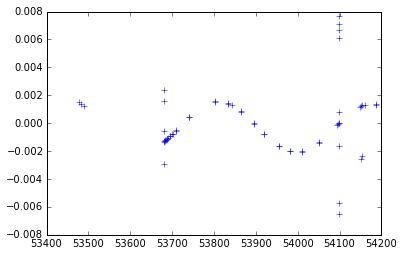

In [21]:
plt.plot(t.get_mjds(), r.time_resids, '+')